In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset
import torch.utils.data as Data
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import copy
from tqdm.notebook import tqdm
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns; sns.set(style='whitegrid')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
!pip install torch-summary
from torchsummary import summary
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Problem and Data Description
In this project we use a dataset of microscope images of actual human cells taken from tumors, which were analyzed and labelled as benign, or non-cancerous, and malignant, or cancerous. There are a few markers for cancerous tumors such as mishapen or missized cells. The training dataset contains about 220,000 images of these microscope slides, with 89,117 malignant cases and 130,908 benign cases. Each image contains 96 rows and 96 columns of pixels, each with RGB channels. The training dataset includes labels for the images (1 for malignant, 0 for benign) but the test dataset does not. This project will use convolution neural networks, pooling layers, and dropout layers to classify images based on the information contained within each pixel. The inclusion of pooling and dropout layers is to reduce computation time and reduce overfitting respectively.

## Exploratory Data Analysis
First we take a look at our label dataframe. This consists of the ids of our training images, which is the same as the file name without the extension or path, and the label associated with that image. Then we split the labels data into two lists of image ids, one for all ids labelled 1, or malignant, and the other for the ids labelled 0, or benign. Using these lists we create a histogram of image counts per label. We also visualize some images from each dataset by displaying the first 50 images for each label set. To use the images later we must add the .tif extension onto each id, so we create a new dataframe identical to the label dataframe but with .tif added to each id. We then pass this dataframe into a custom dataset function that converts our image files into tensor objects. These tensors are resized into 46 by 46 matrices, with a third dimension of size 3 to represent the three RGB channels. The set of tensors is then split into a training and test set so we can evaluate and train our model. Finally, we will use tensor transformations to randomly flip horizontally, flip vertically, or rotate 45 degrees for each image. This will help prevent overfitting and create a more diverse model.

In [3]:
label_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
print(label_df.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [4]:
#Splitting data by label
train_img_path = '/kaggle/input/histopathologic-cancer-detection/train'
validate_img_path = '/kaggle/input/histopathologic-cancer-detection/test'
malignant_ids = label_df.loc[label_df['label']==1]['id'].values
benign_ids = label_df.loc[label_df['label']==0]['id'].values
print(malignant_ids)
print(benign_ids)

['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f' ...
 '309210db7f424edbc22b2d13bf2fa27518b18f5c'
 'd4b854fe38b07fe2831ad73892b3cec877689576'
 'a81f84895ddcd522302ddf34be02eb1b3e5af1cb']
['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08' ...
 '53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6'
 '3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75'
 'f129691c13433f66e1e0671ff1fe80944816f5a2']


In [5]:
#Check pixel count per image
Image.open(train_img_path+'/d4b854fe38b07fe2831ad73892b3cec877689576.tif').size

(96, 96)

Total Count of Malignant Cases: 89117
Total Count of Benign Cases: 130908


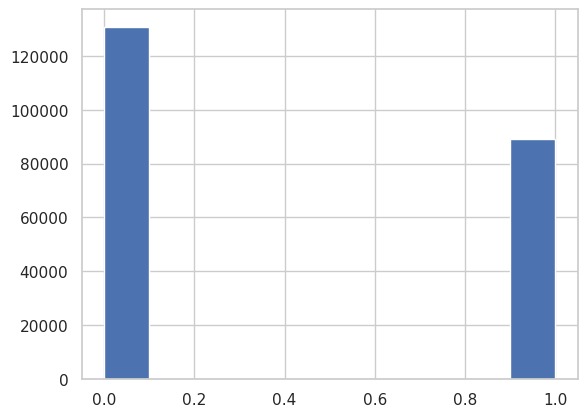

In [6]:
#Training Image Label Count Histogram
plt.hist(label_df['label'])
print(f'Total Count of Malignant Cases: {len(malignant_ids)}\nTotal Count of Benign Cases: {len(benign_ids)}')

Text(0.5, 0.98, 'Benign Cases')

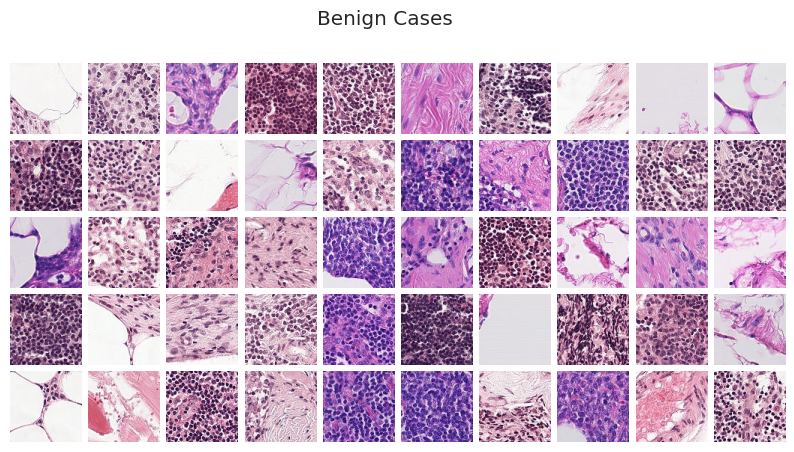

In [7]:
fig, ax = plt.subplots(5, 10, figsize=(10, 5))
plt.subplots_adjust(wspace=0.1, hspace=0)
for i, j in enumerate(benign_ids[:50]):
    filename = os.path.join(train_img_path, j+'.tif')
    img = Image.open(filename)
    plt.subplot(5, 10, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')
plt.suptitle('Benign Cases')

Text(0.5, 0.98, 'Malignant Cases')

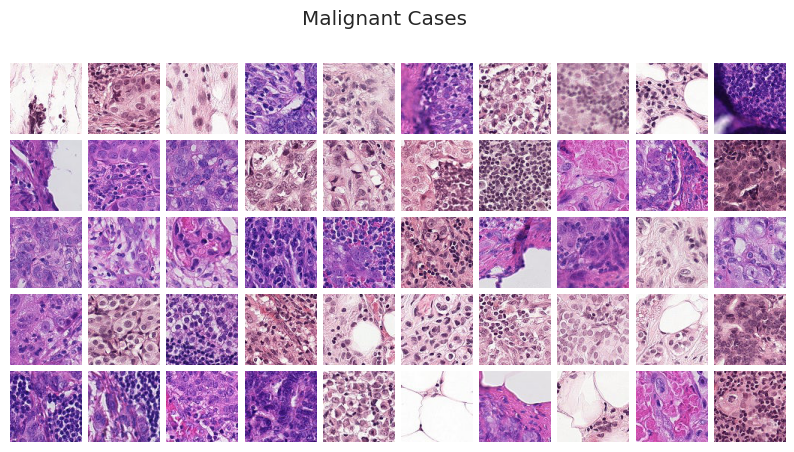

In [8]:
fig, ax = plt.subplots(5, 10, figsize=(10, 5))
plt.subplots_adjust(wspace=0.1, hspace=0)
for i, j in enumerate(malignant_ids[:50]):
    filename = os.path.join(train_img_path, j+'.tif')
    img = Image.open(filename)
    plt.subplot(5, 10, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')
plt.suptitle('Malignant Cases')

In [9]:
file_label_df = label_df
file_label_df['id'] = file_label_df['id'] + '.tif'
#file_label_df.set_index('id', inplace=True)
file_label_df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576.tif,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75.tif,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2.tif,0


In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, image_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.image_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform
        
        file_names = self.img_labels['id']
        labels = self.img_labels['label']
        idx_choose = np.random.choice(np.arange(len(file_names)), 10000, replace=False).tolist()
        sample_files = [file_names[x] for x in idx_choose]
        self.sample_labels = [labels[x] for x in idx_choose]
        self.sample_full_file_names = [os.path.join(self.image_dir, f) for f in sample_files]
        
        
    def __len__(self):
        return len(self.sample_full_file_names)
    
    def __getitem__(self, idx):
        image = Image.open(self.sample_full_file_names[idx])
        label = self.sample_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [11]:
transformer = transforms.Compose([transforms.ToTensor(), transforms.Resize((46,46))])

In [12]:
image_dataset = CustomImageDataset(file_label_df, train_img_path, transform=transformer)

In [13]:
check_img, check_label = image_dataset.__getitem__(10)
print(check_img.shape, torch.min(check_img), torch.max(check_img))

torch.Size([3, 46, 46]) tensor(0.0366) tensor(1.0000)


In [14]:
train_len = int(len(image_dataset)*0.8)
train_dataset, test_dataset = Data.random_split(image_dataset, [train_len, len(image_dataset)-train_len])

In [15]:
print(f'Train Dataset Size: {len(train_dataset)}\nTest Dataset Size: {len(test_dataset)}')

Train Dataset Size: 8000
Test Dataset Size: 2000


In [16]:
print(train_dataset[0])

(tensor([[[0.3819, 0.4519, 0.4057,  ..., 0.7712, 0.7963, 0.8552],
         [0.4127, 0.4939, 0.5226,  ..., 0.6926, 0.6224, 0.6696],
         [0.4866, 0.5798, 0.5364,  ..., 0.8290, 0.8348, 0.9215],
         ...,
         [0.6997, 0.6686, 0.7484,  ..., 0.5940, 0.7691, 0.9747],
         [0.7011, 0.6887, 0.6556,  ..., 0.6279, 0.8480, 0.5875],
         [0.9307, 0.9255, 0.8307,  ..., 0.6440, 0.8329, 0.9506]],

        [[0.2127, 0.2660, 0.2106,  ..., 0.4776, 0.4875, 0.5325],
         [0.2051, 0.2721, 0.3038,  ..., 0.4152, 0.3382, 0.3813],
         [0.2401, 0.3299, 0.3016,  ..., 0.5849, 0.6011, 0.6960],
         ...,
         [0.4135, 0.3692, 0.4469,  ..., 0.3792, 0.6421, 0.9131],
         [0.4463, 0.4245, 0.3863,  ..., 0.3523, 0.6491, 0.4532],
         [0.7744, 0.7179, 0.5806,  ..., 0.3486, 0.5532, 0.7075]],

        [[0.5887, 0.6211, 0.5513,  ..., 0.7136, 0.7057, 0.7610],
         [0.5654, 0.6261, 0.6520,  ..., 0.6657, 0.5974, 0.6577],
         [0.5770, 0.6723, 0.6531,  ..., 0.7937, 0.8121, 0

In [17]:
training_transformations = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                               transforms.RandomVerticalFlip(), 
                                               transforms.RandomRotation(45),
                                               transforms.ToTensor()])
test_transformations = transforms.Compose([transforms.ToTensor()])

train_dataset.transform = training_transformations
test_dataset.transform = test_transformations
train_dataset.transform

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)

## Model Architecture
There are two architectures tested in this notebook. Firstly, the similarities between these architectures are the four convolution layers followed by two fully connected layers outputing to a final 2 neuron output. Each of these layers uses a ReLu function. Finally the output is used by a log_softmax function to output the probabilities for each of the two possible layers. The differences between the two architectures are the inclusion of pooling layers and a dropout layer in the first network architecture. These pooling layers occur after each convolution layer, and there is one dropout layer between the two fully connected layers. These are all missing from the second architecture. The pooling layers should reduce computation time and the dropout layer fights overfitting. Here I chose to use Cross Entropy Loss as the loss function to be optimized. This loss function is particularly good for punishing low confidence correct classifications and high confidence incorrect classifications. There is a version of this equation included in pytorch designed to work for binary classification, which fits our problem here.

In [18]:
def getConvOutputShape(inh, inw, conv, pool=2):
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation
    outh = np.floor((inh+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    outw = np.floor((inw+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    
    if pool:
        outh = outh/pool
        outw = outw/pool
    return int(outh), int(outw)

In [19]:
class Network1(nn.Module):
    def __init__(self, parameters):
        super(Network1, self).__init__()
        
        Hinput, Winput, Cinput = parameters[0]
        initial_filters = parameters[1]
        fc1n = parameters[2]
        self.dropout_rate= parameters[3]
        
        #print('0', Hinput, Winput)
        self.conv1 = nn.Conv2d(Cinput, initial_filters, kernel_size=3)
        h, w = getConvOutputShape(Hinput, Winput, self.conv1)
        #print('1', h, w)
        self.conv2 = nn.Conv2d(initial_filters, 2*initial_filters, kernel_size=3)
        h, w = getConvOutputShape(h, w, self.conv2)
        #print('2', h, w)
        self.conv3 = nn.Conv2d(2*initial_filters, 4*initial_filters, kernel_size=3)
        h, w = getConvOutputShape(h, w, self.conv3)
        #print('3', h, w)
        self.conv4 = nn.Conv2d(4*initial_filters, 8*initial_filters, kernel_size=3)
        h, w = getConvOutputShape(h, w, self.conv4)
        #print('4', h, w)
        
        self.flat_size=h*w*8*initial_filters
        #print(self.flat_size)
        self.fc1 = nn.Linear(self.flat_size, fc1n)
        self.fc2 = nn.Linear(fc1n, 2)
        
        
    def forward(self, X):
        
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        
        X = X.view(-1, self.flat_size)
        #print(self.flat_size)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        #print(X.size())
        return F.log_softmax(X, dim=1)
        

In [20]:
class Network2(nn.Module):
    def __init__(self, parameters):
        super(Network2, self).__init__()
        
        Hinput, Winput, Cinput = parameters[0]
        initial_filters = parameters[1]
        fc1n = parameters[2]
        
        #print('0', Hinput, Winput)
        self.conv1 = nn.Conv2d(Cinput, initial_filters, kernel_size=3)
        h, w = getConvOutputShape(Hinput, Winput, self.conv1, pool=0)
        #print('1', h, w)
        self.conv2 = nn.Conv2d(initial_filters, 2*initial_filters, kernel_size=3)
        h, w = getConvOutputShape(h, w, self.conv2, pool=0)
        #print('2', h, w)
        self.conv3 = nn.Conv2d(2*initial_filters, 4*initial_filters, kernel_size=3)
        h, w = getConvOutputShape(h, w, self.conv3, pool=0)
        #print('3', h, w)
        self.conv4 = nn.Conv2d(4*initial_filters, 8*initial_filters, kernel_size=3)
        h, w = getConvOutputShape(h, w, self.conv4, pool=0)
        #print('4', h, w)
        
        self.flat_size=h*w*8*initial_filters
        #print(self.flat_size)
        self.fc1 = nn.Linear(self.flat_size, fc1n)
        self.fc2 = nn.Linear(fc1n, 2)
    
    def forward(self, X):
        
        X = F.relu(self.conv1(X))
        
        X = F.relu(self.conv2(X))
        
        X = F.relu(self.conv3(X))
        
        X = F.relu(self.conv4(X))
        #print(X.size())
        X = X.view(-1, self.flat_size)
        #print(self.flat_size)
        X = F.relu(self.fc1(X))
        
        X = self.fc2(X)
        #print(F.log_softmax(X, dim=1).size())
        return F.log_softmax(X, dim=1)

In [21]:
loss_func = nn.NLLLoss(reduction='sum')

In [22]:
def get_lr(opt):
    return opt.param_groups[0]['lr']

In [23]:
def loss_per_batch(loss_func, output, target, opt=None):
    #print(output.size(), target.size())
    loss = loss_func(output, target)
    pred = output.argmax(dim=1, keepdim=True)
    batch_metric = pred.eq(target.view_as(pred)).sum().item()
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), batch_metric

In [24]:
def loss_epoch(model, loss_func, dataset, opt=None):
    run_loss = 0.0
    total_metric = 0.0
    len_data = len(dataset.dataset)
    
    for xb, yb in dataset:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)
        #print(output)
        #print(yb)
        batch_loss, batch_metric = loss_per_batch(loss_func, output, yb, opt)
        
        run_loss += batch_loss
        if batch_metric is not None:
            total_metric += batch_metric
            
    avg_loss = run_loss / float(len_data)
    avg_metric = total_metric / float(len_data)
    
    return avg_loss, avg_metric

In [25]:
def train_and_eval(model, parameters):
    epochs = parameters[0]
    loss_func = parameters[1]
    opt = parameters[2]
    train_data = parameters[3]
    test_data = parameters[4]
    lr_scheduler = parameters[5]
    
    loss_history = {"train":[], "test":[]}
    metric_history = {"train":[], "test":[]}
    best_model_weights = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    for epoch in tqdm(range(epochs)):
        #get learning rate
        current_lr = get_lr(opt)
        print(f'Current Epoch: {epoch} of {epochs}\nCurrent Learning Rate: {current_lr}')
        
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_data, opt)
        
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            test_loss, test_metric = loss_epoch(model, loss_func, test_data)
        
        if (test_loss < best_loss):
            best_loss = test_loss
            best_model_weights = copy.deepcopy(model.state_dict())
        
        loss_history['test'].append(test_loss)
        metric_history['test'].append(test_metric)
        
        lr_scheduler.step(test_loss)
        if current_lr != get_lr(opt):
            model.load_state_dict(best_model_weights)
        
    model.load_state_dict(best_model_weights)
    
    return model, loss_history, metric_history

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def run_model(network, base_params, loss_func, batch_len=80, learning_rate=3e-4, pat=10, eps=50, verbose=False):
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_len, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_len, shuffle=False)
    
    
    if network == 1:
        cnn_model = Network1(base_params)
    elif network == 2:
        cnn_model = Network2(base_params)
    
    model = cnn_model.to(device)
    
    if verbose:
        for x, y in train_dataloader:
            print("Dataloader Shape:", x.shape, y)
            break
        print(summary(cnn_model, input_size=(46, 46, 3), device=device.type))
    
    optimizer = optim.SGD(cnn_model.parameters(), lr=learning_rate)
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience = pat)
    
    parameter_train = [eps, loss_func, optimizer, train_dataloader, test_dataloader, lr_scheduler]
    cnn_model, loss_hist, metric_hist = train_and_eval(cnn_model, parameter_train)
    
    if verbose:
        print(loss_hist, metric_hist)

    fig,ax = plt.subplots(1,2,figsize=(12,5))

    sns.lineplot(x=[*range(1,eps+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
    sns.lineplot(x=[*range(1,eps+1)],y=loss_hist["test"],ax=ax[0],label='loss_hist["test"]')
    sns.lineplot(x=[*range(1,eps+1)],y=metric_hist["train"],ax=ax[1],label='metric_hist["train"]')
    sns.lineplot(x=[*range(1,eps+1)],y=metric_hist["test"],ax=ax[1],label='metric_hist["test"]')
    plt.title(f'Convergence History: (ilr={learning_rate}, eps={eps}, batch={batch_len}, patience={pat})')
    
    return cnn_model

## Results and Analysis
In this section of the notebook the models are trained with varying hyperparameters. 7 models in total were trained, 4 for the first architecture and 3 for the second. I began by using the default hyper parameters including 50 epochs, a learning rate equal to 0.0003, a learning rate scheduler patience of 10, and a batch size of 80 images. This model does not appear to reach convergence in 50 epochs, so I increased the timeframe for the second model. I then reduced the batch size and increased the timeframe further, as a smaller batch requires more epochs to converge as well. This also appeared to not quite converge. Then, I tried a larger batch size with the original epoch count which also needed more time to converge. Finally for the first architecture I increased the batch count to 120, reducing the time to converge, and then increased the epoch count to 150. We finally see the test and training sets diverge in performance, around epoch 120, with significantly higher performance than the other models.

Dataloader Shape: torch.Size([80, 3, 46, 46]) tensor([1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 0])
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            6,500
├─Linear: 1-6                            202
Total params: 31,230
Trainable params: 31,230
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            6,500


  0%|          | 0/50 [00:00<?, ?it/s]

Current Epoch: 0 of 50
Current Learning Rate: 0.0003
Current Epoch: 1 of 50
Current Learning Rate: 0.0003
Current Epoch: 2 of 50
Current Learning Rate: 0.0003
Current Epoch: 3 of 50
Current Learning Rate: 0.0003
Current Epoch: 4 of 50
Current Learning Rate: 0.0003
Current Epoch: 5 of 50
Current Learning Rate: 0.0003
Current Epoch: 6 of 50
Current Learning Rate: 0.0003
Current Epoch: 7 of 50
Current Learning Rate: 0.0003
Current Epoch: 8 of 50
Current Learning Rate: 0.0003
Current Epoch: 9 of 50
Current Learning Rate: 0.0003
Current Epoch: 10 of 50
Current Learning Rate: 0.0003
Current Epoch: 11 of 50
Current Learning Rate: 0.0003
Current Epoch: 12 of 50
Current Learning Rate: 0.0003
Current Epoch: 13 of 50
Current Learning Rate: 0.0003
Current Epoch: 14 of 50
Current Learning Rate: 0.0003
Current Epoch: 15 of 50
Current Learning Rate: 0.0003
Current Epoch: 16 of 50
Current Learning Rate: 0.0003
Current Epoch: 17 of 50
Current Learning Rate: 0.0003
Current Epoch: 18 of 50
Current Learni

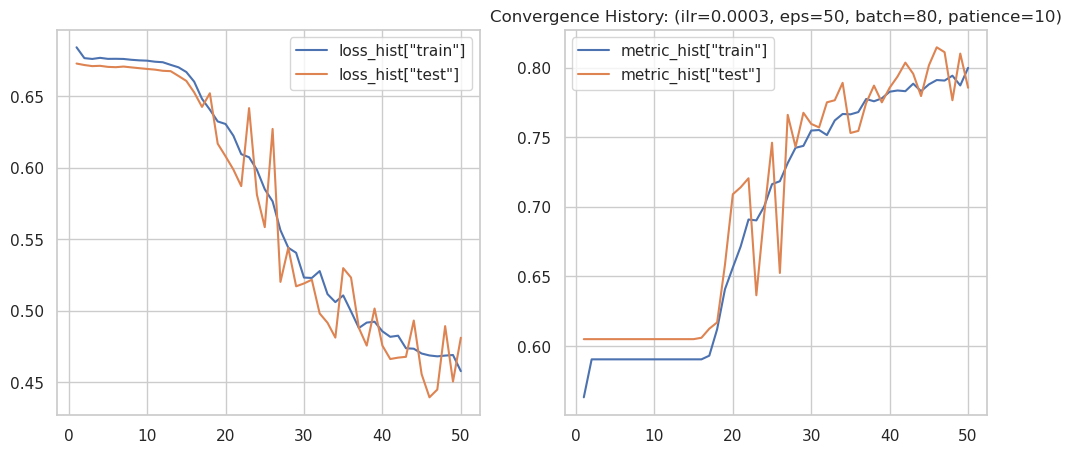

In [30]:
run_model(1, [(46, 46, 3), 8, 100, 0.25], loss_func, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Current Epoch: 0 of 100
Current Learning Rate: 0.0003
Current Epoch: 1 of 100
Current Learning Rate: 0.0003
Current Epoch: 2 of 100
Current Learning Rate: 0.0003
Current Epoch: 3 of 100
Current Learning Rate: 0.0003
Current Epoch: 4 of 100
Current Learning Rate: 0.0003
Current Epoch: 5 of 100
Current Learning Rate: 0.0003
Current Epoch: 6 of 100
Current Learning Rate: 0.0003
Current Epoch: 7 of 100
Current Learning Rate: 0.0003
Current Epoch: 8 of 100
Current Learning Rate: 0.0003
Current Epoch: 9 of 100
Current Learning Rate: 0.0003
Current Epoch: 10 of 100
Current Learning Rate: 0.0003
Current Epoch: 11 of 100
Current Learning Rate: 0.0003
Current Epoch: 12 of 100
Current Learning Rate: 0.0003
Current Epoch: 13 of 100
Current Learning Rate: 0.0003
Current Epoch: 14 of 100
Current Learning Rate: 0.0003
Current Epoch: 15 of 100
Current Learning Rate: 0.0003
Current Epoch: 16 of 100
Current Learning Rate: 0.0003
Current Epoch: 17 of 100
Current Learning Rate: 0.0003
Current Epoch: 18 of

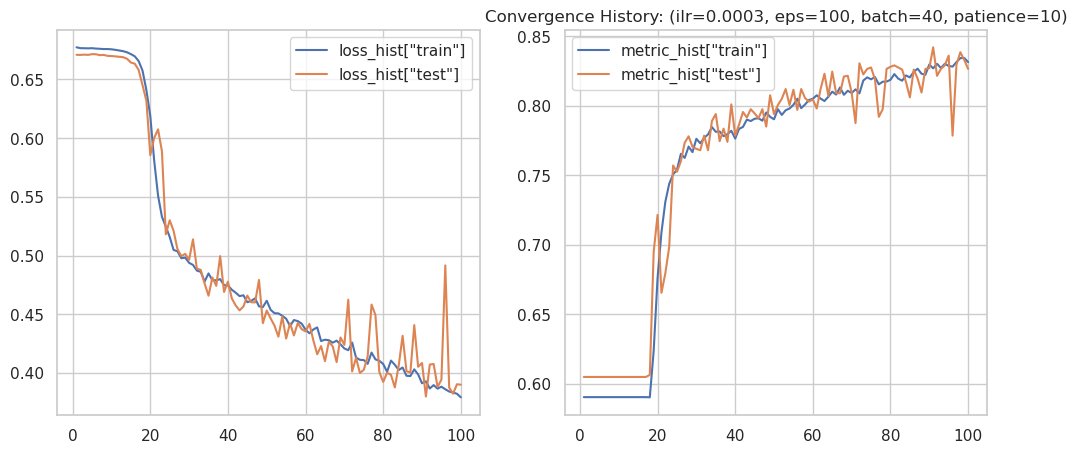

In [31]:
run_model(1, [(46, 46, 3), 8, 100, 0.25], loss_func, batch_len=40, eps=100)

  0%|          | 0/50 [00:00<?, ?it/s]

Current Epoch: 0 of 50
Current Learning Rate: 0.0003
Current Epoch: 1 of 50
Current Learning Rate: 0.0003
Current Epoch: 2 of 50
Current Learning Rate: 0.0003
Current Epoch: 3 of 50
Current Learning Rate: 0.0003
Current Epoch: 4 of 50
Current Learning Rate: 0.0003
Current Epoch: 5 of 50
Current Learning Rate: 0.0003
Current Epoch: 6 of 50
Current Learning Rate: 0.0003
Current Epoch: 7 of 50
Current Learning Rate: 0.0003
Current Epoch: 8 of 50
Current Learning Rate: 0.0003
Current Epoch: 9 of 50
Current Learning Rate: 0.0003
Current Epoch: 10 of 50
Current Learning Rate: 0.0003
Current Epoch: 11 of 50
Current Learning Rate: 0.0003
Current Epoch: 12 of 50
Current Learning Rate: 0.0003
Current Epoch: 13 of 50
Current Learning Rate: 0.0003
Current Epoch: 14 of 50
Current Learning Rate: 0.0003
Current Epoch: 15 of 50
Current Learning Rate: 0.0003
Current Epoch: 16 of 50
Current Learning Rate: 0.0003
Current Epoch: 17 of 50
Current Learning Rate: 0.0003
Current Epoch: 18 of 50
Current Learni

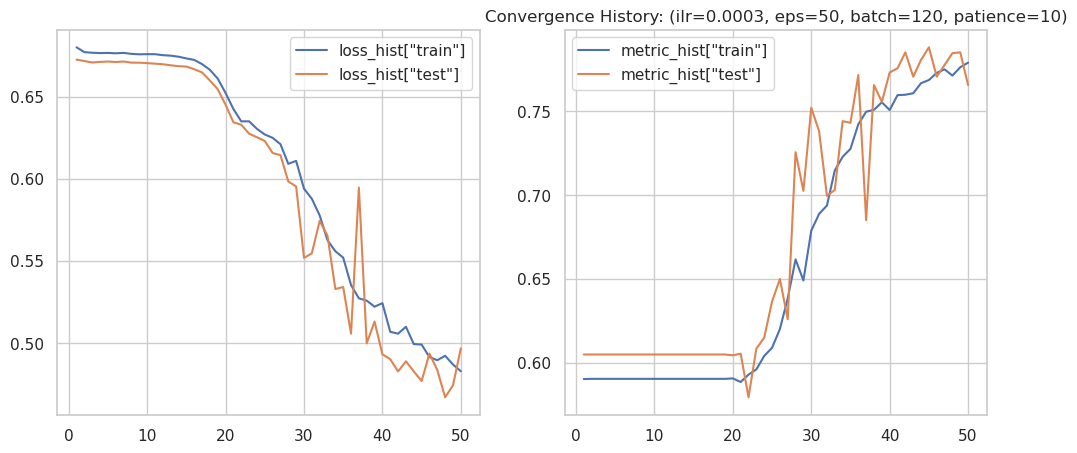

In [32]:
run_model(1, [(46, 46, 3), 8, 100, 0.25], loss_func, batch_len=120)

  0%|          | 0/150 [00:00<?, ?it/s]

Current Epoch: 0 of 150
Current Learning Rate: 0.0003
Current Epoch: 1 of 150
Current Learning Rate: 0.0003
Current Epoch: 2 of 150
Current Learning Rate: 0.0003
Current Epoch: 3 of 150
Current Learning Rate: 0.0003
Current Epoch: 4 of 150
Current Learning Rate: 0.0003
Current Epoch: 5 of 150
Current Learning Rate: 0.0003
Current Epoch: 6 of 150
Current Learning Rate: 0.0003
Current Epoch: 7 of 150
Current Learning Rate: 0.0003
Current Epoch: 8 of 150
Current Learning Rate: 0.0003
Current Epoch: 9 of 150
Current Learning Rate: 0.0003
Current Epoch: 10 of 150
Current Learning Rate: 0.0003
Current Epoch: 11 of 150
Current Learning Rate: 0.0003
Current Epoch: 12 of 150
Current Learning Rate: 0.0003
Current Epoch: 13 of 150
Current Learning Rate: 0.0003
Current Epoch: 14 of 150
Current Learning Rate: 0.0003
Current Epoch: 15 of 150
Current Learning Rate: 0.0003
Current Epoch: 16 of 150
Current Learning Rate: 0.0003
Current Epoch: 17 of 150
Current Learning Rate: 0.0003
Current Epoch: 18 of

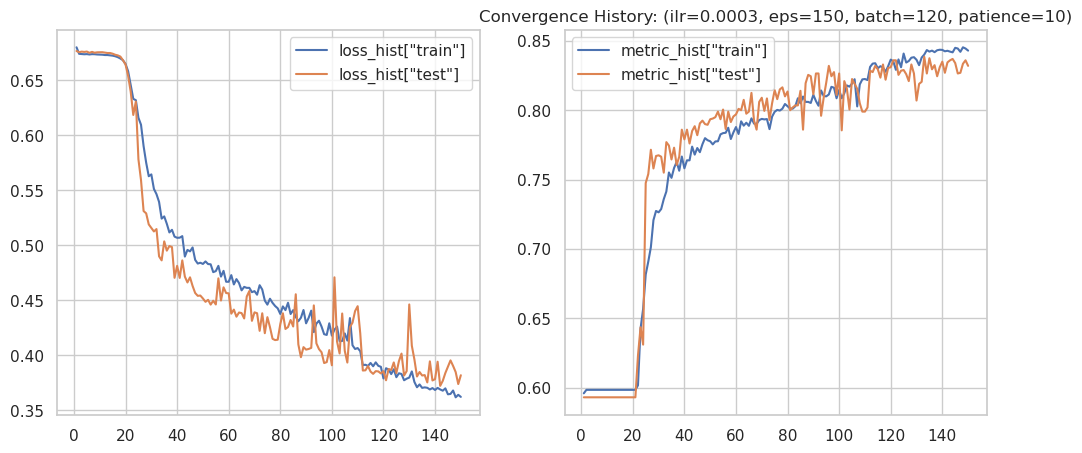

In [25]:
run_model(1, [(46, 46, 3), 8, 100, 0.25], loss_func, batch_len=120, eps=150)

## Second Architecture
As before, I began training this model architecture (the one without pooling/dropout) with the default settings. Epochs=50,batch_size=80, learning_rate=0.0003. The vast increase in trainable parameters led to much faster convergence, as this model converges in only about 25 epochs, whereas the previous model didn't converge within 50 with default hyperparameters. Its quick convergence comes at a cost of performance, as it did not reach as small a loss function or as great an accuracy. None of these trained models quite compete with the performance of the first architecture, and they are all quite similar despite the same hyperparameter tuning as the first architecture received. It seems like the lack of dropout causes overfitting to occur much faster.

Dataloader Shape: torch.Size([80, 3, 46, 46]) tensor([1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 0])
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            9,241,700
├─Linear: 1-6                            202
Total params: 9,266,430
Trainable params: 9,266,430
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                        

  0%|          | 0/50 [00:00<?, ?it/s]

Current Epoch: 0 of 50
Current Learning Rate: 0.0003
Current Epoch: 1 of 50
Current Learning Rate: 0.0003
Current Epoch: 2 of 50
Current Learning Rate: 0.0003
Current Epoch: 3 of 50
Current Learning Rate: 0.0003
Current Epoch: 4 of 50
Current Learning Rate: 0.0003
Current Epoch: 5 of 50
Current Learning Rate: 0.0003
Current Epoch: 6 of 50
Current Learning Rate: 0.0003
Current Epoch: 7 of 50
Current Learning Rate: 0.0003
Current Epoch: 8 of 50
Current Learning Rate: 0.0003
Current Epoch: 9 of 50
Current Learning Rate: 0.0003
Current Epoch: 10 of 50
Current Learning Rate: 0.0003
Current Epoch: 11 of 50
Current Learning Rate: 0.0003
Current Epoch: 12 of 50
Current Learning Rate: 0.0003
Current Epoch: 13 of 50
Current Learning Rate: 0.0003
Current Epoch: 14 of 50
Current Learning Rate: 0.0003
Current Epoch: 15 of 50
Current Learning Rate: 0.0003
Current Epoch: 16 of 50
Current Learning Rate: 0.0003
Current Epoch: 17 of 50
Current Learning Rate: 0.0003
Current Epoch: 18 of 50
Current Learni

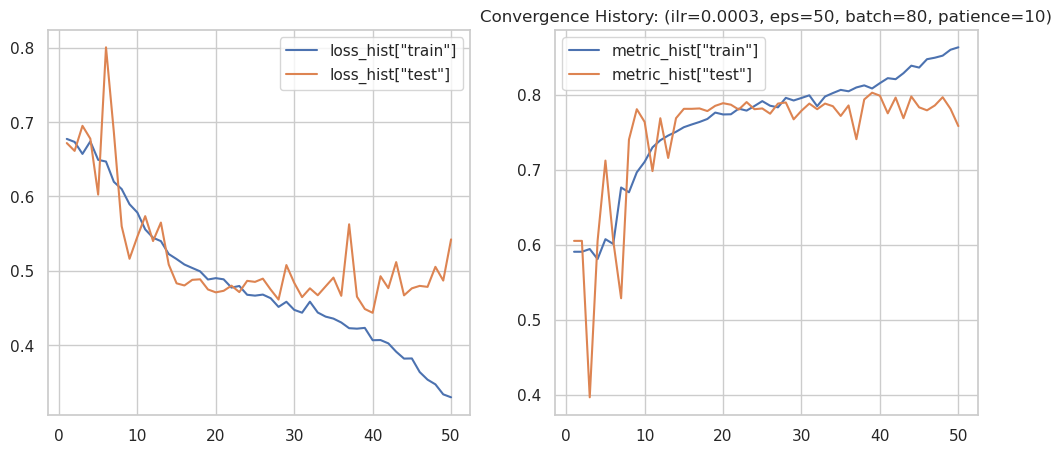

In [35]:
run_model(2, [(46, 46, 3), 8, 100], loss_func, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

Current Epoch: 0 of 50
Current Learning Rate: 0.0003
Current Epoch: 1 of 50
Current Learning Rate: 0.0003
Current Epoch: 2 of 50
Current Learning Rate: 0.0003
Current Epoch: 3 of 50
Current Learning Rate: 0.0003
Current Epoch: 4 of 50
Current Learning Rate: 0.0003
Current Epoch: 5 of 50
Current Learning Rate: 0.0003
Current Epoch: 6 of 50
Current Learning Rate: 0.0003
Current Epoch: 7 of 50
Current Learning Rate: 0.0003
Current Epoch: 8 of 50
Current Learning Rate: 0.0003
Current Epoch: 9 of 50
Current Learning Rate: 0.0003
Current Epoch: 10 of 50
Current Learning Rate: 0.0003
Current Epoch: 11 of 50
Current Learning Rate: 0.0003
Current Epoch: 12 of 50
Current Learning Rate: 0.0003
Current Epoch: 13 of 50
Current Learning Rate: 0.0003
Current Epoch: 14 of 50
Current Learning Rate: 0.0003
Current Epoch: 15 of 50
Current Learning Rate: 0.0003
Current Epoch: 16 of 50
Current Learning Rate: 0.0003
Current Epoch: 17 of 50
Current Learning Rate: 0.0003
Current Epoch: 18 of 50
Current Learni

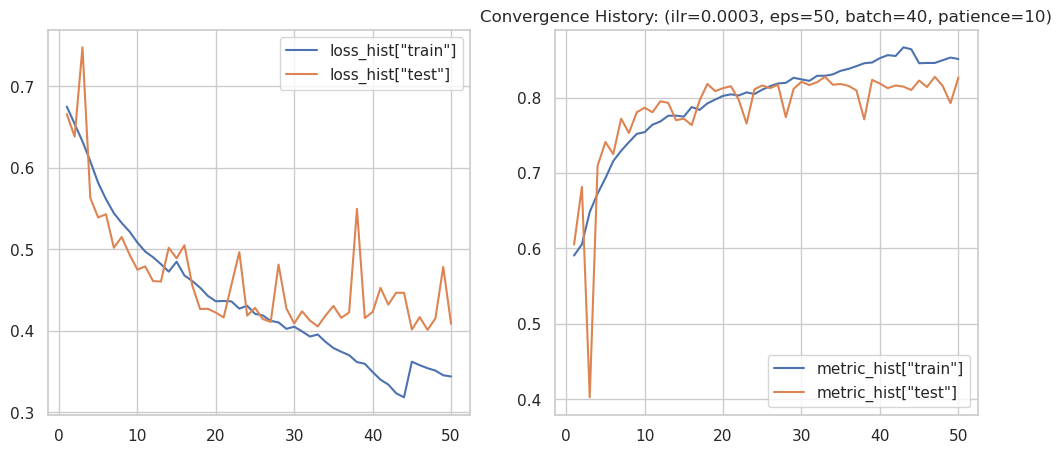

In [36]:
run_model(2, [(46, 46, 3), 8, 100], loss_func, batch_len=40)

  0%|          | 0/100 [00:00<?, ?it/s]

Current Epoch: 0 of 100
Current Learning Rate: 0.0003
Current Epoch: 1 of 100
Current Learning Rate: 0.0003
Current Epoch: 2 of 100
Current Learning Rate: 0.0003
Current Epoch: 3 of 100
Current Learning Rate: 0.0003
Current Epoch: 4 of 100
Current Learning Rate: 0.0003
Current Epoch: 5 of 100
Current Learning Rate: 0.0003
Current Epoch: 6 of 100
Current Learning Rate: 0.0003
Current Epoch: 7 of 100
Current Learning Rate: 0.0003
Current Epoch: 8 of 100
Current Learning Rate: 0.0003
Current Epoch: 9 of 100
Current Learning Rate: 0.0003
Current Epoch: 10 of 100
Current Learning Rate: 0.0003
Current Epoch: 11 of 100
Current Learning Rate: 0.0003
Current Epoch: 12 of 100
Current Learning Rate: 0.0003
Current Epoch: 13 of 100
Current Learning Rate: 0.0003
Current Epoch: 14 of 100
Current Learning Rate: 0.0003
Current Epoch: 15 of 100
Current Learning Rate: 0.0003
Current Epoch: 16 of 100
Current Learning Rate: 0.0003
Current Epoch: 17 of 100
Current Learning Rate: 0.0003
Current Epoch: 18 of

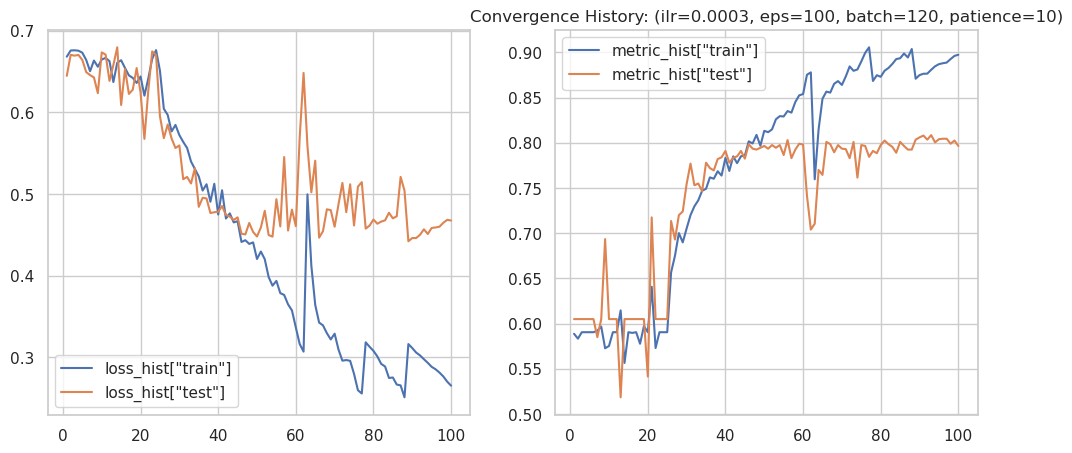

In [37]:
run_model(2, [(46, 46, 3), 8, 100], loss_func, batch_len=120, eps=100)

## Getting Best Model For Use on Validation Set
As we saw above, the best model used occurred during the training of our 150 epoch, 120 batch size, first architecture model. The convergence appeared to begin around the 120th epoch, so that is the model we'll be using on our submission dataset.

  0%|          | 0/120 [00:00<?, ?it/s]

Current Epoch: 0 of 120
Current Learning Rate: 0.0003
Current Epoch: 1 of 120
Current Learning Rate: 0.0003
Current Epoch: 2 of 120
Current Learning Rate: 0.0003
Current Epoch: 3 of 120
Current Learning Rate: 0.0003
Current Epoch: 4 of 120
Current Learning Rate: 0.0003
Current Epoch: 5 of 120
Current Learning Rate: 0.0003
Current Epoch: 6 of 120
Current Learning Rate: 0.0003
Current Epoch: 7 of 120
Current Learning Rate: 0.0003
Current Epoch: 8 of 120
Current Learning Rate: 0.0003
Current Epoch: 9 of 120
Current Learning Rate: 0.0003
Current Epoch: 10 of 120
Current Learning Rate: 0.0003
Current Epoch: 11 of 120
Current Learning Rate: 0.0003
Current Epoch: 12 of 120
Current Learning Rate: 0.0003
Current Epoch: 13 of 120
Current Learning Rate: 0.0003
Current Epoch: 14 of 120
Current Learning Rate: 0.0003
Current Epoch: 15 of 120
Current Learning Rate: 0.0003
Current Epoch: 16 of 120
Current Learning Rate: 0.0003
Current Epoch: 17 of 120
Current Learning Rate: 0.0003
Current Epoch: 18 of

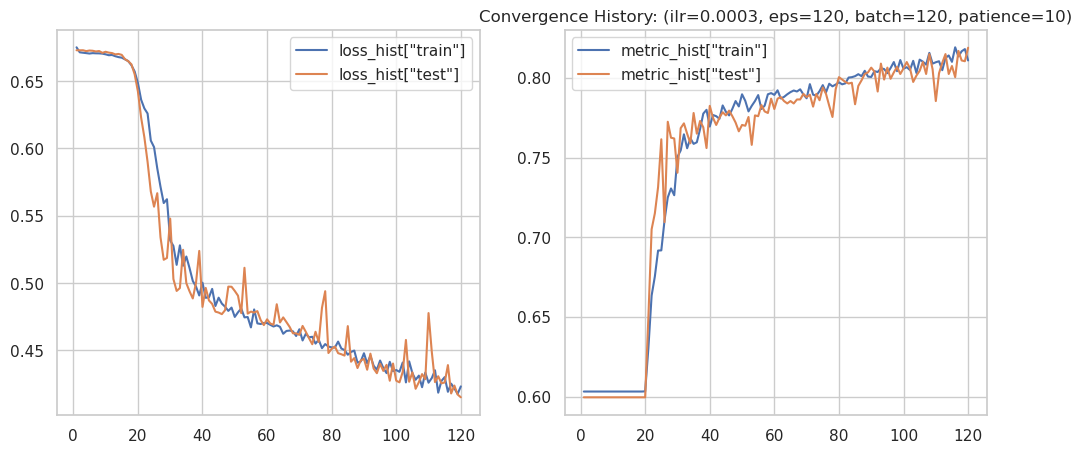

In [27]:
best_model = run_model(1, [(46, 46, 3), 8, 100, 0.25], loss_func, batch_len=120, eps=120)

In [34]:
class CustomImageTestDataset(Dataset):
    def __init__(self, data_dir, transform):

        self.image_dir = os.path.join(data_dir, 'test')
        self.transform = transform
        
        file_names = os.listdir(self.image_dir)
        self.full_file_names = [os.path.join(self.image_dir,f) for f in file_names]
        
        label_csv = "sample_submission.csv"
        label_csv_path = os.path.join(data_dir, label_csv)
        label_df = pd.read_csv(label_csv_path)
        
        label_df.set_index('id', inplace=True)
        
        self.labels = [label_df.loc[filename[:-4]].values[0] for filename in file_names]
        
    def __len__(self):
        return len(self.full_file_names)
    
    def __getitem__(self, idx):
        image = Image.open(self.full_file_names[idx])
        image = self.transform(image)

        return image, self.labels[idx]

In [35]:
sub_path = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'
sample_sub_df = pd.read_csv(sub_path)
sample_sub_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [36]:
directory = '/kaggle/input/histopathologic-cancer-detection/'
data_transformer = transforms.Compose([transforms.ToTensor(), transforms.Resize((46, 46))])
custom_test_dataset = CustomImageTestDataset(directory, data_transformer)
print(len(custom_test_dataset))

57458


In [37]:
def inference(model, dataset, device):
    len_data = len(dataset)
    y_out=torch.zeros(len_data, 2)
    y_gt=np.zeros((len_data), dtype="uint8")
    model = model.to(device)
    
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x, y = dataset[i]
            y_gt[i] = y
            y_out[i] = model(x.unsqueeze(0).to(device))
    return y_out.numpy(), y_gt

In [38]:
y_test_out,_ = inference(best_model, custom_test_dataset, device)

  0%|          | 0/57458 [00:00<?, ?it/s]

In [44]:
y_test_pred=np.argmax(y_test_out,axis=1)
print(y_test_pred.shape)
y_test_pred

(57458,)


array([0, 0, 0, ..., 1, 0, 0])

In [50]:
output_df = sample_sub_df
output_df['label'] = y_test_pred
output_df.to_csv("submission.csv", index=False)

## Conclusion
This notebook really shows how much of an impact a dropout layer can have on the overfitting of a model. Combined with a learning rate scheduler, even with increases to batch size and epoch count, it took such a long time to reach convergence. However, this did have a small positive impact on the accuracy of the model. Thankfully the pooling helps reduce the computation time and fits well with these slowly-converging models.
To improve, more hyper parameters could be tested. The initial learning rate wasn't tuned, although the scheduler essentially tunes it during training. The dropout rate could have been tested as well as the patience used in learning rate scheduling.